In [1]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 10

# Modelado y Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster

# Configuración warnings
# ==============================================================================
import warnings
# warnings.filterwarnings('ignore')

/home/ian/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Descarga de datos
# ==============================================================================
url = 'https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o_exog.csv'
datos = pd.read_csv(url, sep=',')

In [3]:
print(f'Número de filas con missing values: {datos.isnull().any(axis=1).mean()}')


Número de filas con missing values: 0.0


In [4]:
# Verificar que un índice temporal está completo
# ==============================================================================
#(datos.index == pd.date_range(
#                    start = datos.index.min(),
#                    end   = datos.index.max(),
#                    freq  = datos.index.freq)
#).all()

Fechas train : 0 --- 158  (n=159)
Fechas test  : 159 --- 194  (n=36)


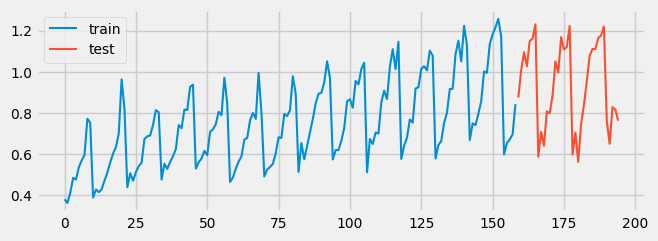

In [5]:
# Separación datos train-test
# ==============================================================================
steps = 36
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

print(f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

fig, ax = plt.subplots(figsize=(7, 2.5))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
ax.legend();

In [6]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 6
             )

forecaster.fit(y=datos_train['y'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6] 
Transformer for y: None 
Transformer for exog: None 
Window size: 6 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [0, 158] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2023-07-29 11:48:55 
Last fit date: 2023-07-29 11:48:55 
Skforecast version: 0.9.1 
Python version: 3.10.6 
Forecaster id: None 

In [7]:
# Predicciones
# ==============================================================================
steps = 36
predicciones = forecaster.predict(steps=steps)
predicciones.head(5)

159    0.878756
160    0.882167
161    0.973184
162    0.983678
163    0.849494
Name: pred, dtype: float64

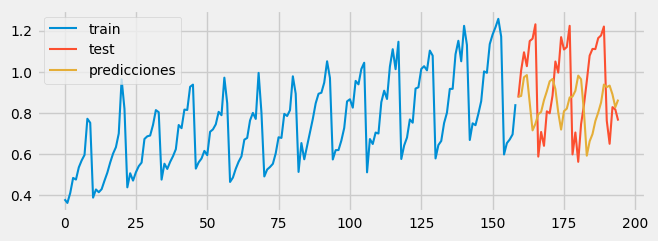

In [8]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 2.5))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

In [9]:
# Error test
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test['y'],
                y_pred = predicciones
            )

print(f"Error de test (mse): {error_mse}")

Error de test (mse): 0.07326833976120374


In [10]:
# Grid search de hiperparámetros
# ==============================================================================
steps = 36
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12 # Este valor será remplazado en el grid search
             )

# Lags utilizados como predictores
lags_grid = [10, 20]

# Hiperparámetros del regresor
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}

resultados_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = datos_train['y'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = False,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(datos_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        n_jobs             = 'auto',
                        verbose            = False
                  )

Number of models compared: 12.


lags grid: 100%|██████████| 2/2 [00:16<00:00,  8.34s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'max_depth': 3, 'n_estimators': 500}
  Backtesting metric: 0.021992765856921042



In [11]:
# Resultados Grid Search
# ==============================================================================
resultados_grid

,lags,params,mean_squared_error,max_depth,n_estimators
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 500}",0.021993,3,500
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 500}",0.022114,5,500
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 500}",0.022224,10,500
8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 100}",0.022530,5,100
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 100}",0.022569,3,100
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 100}",0.023400,10,100
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 100}",0.063144,3,100
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 500}",0.064775,3,500
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 100}",0.066307,10,100
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 100}",0.067151,5,100


In [14]:
# Crear y entrenar forecaster con mejores hiperparámetros
# ==============================================================================
regressor = RandomForestRegressor(max_depth=3, n_estimators=500, random_state=123)
forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 20
             )

forecaster.fit(y=datos_train['y'])

In [15]:
# Predicciones
# ==============================================================================
predicciones = forecaster.predict(steps=steps)

In [ ]:
# Error test
# ==============================================================================
error_mse = mean_squared_error(y_true = datos_test['y'], y_pred = predicciones)
print(f"Error de test (mse) {error_mse}")

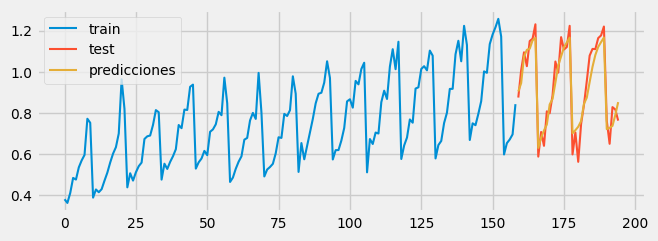

In [16]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 2.5))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

In [17]:
# Error de test
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test['y'],
                y_pred = predicciones
            )

print(f"Error de test (mse) {error_mse}")

Error de test (mse) 0.004392699665157793


In [18]:
# Backtesting
# ==============================================================================
steps = 36
n_backtesting = 36*3 # Se separan para el backtest los últimos 9 años

metrica, predicciones_backtest = backtesting_forecaster(
                                    forecaster         = forecaster,
                                    y                  = datos['y'],
                                    initial_train_size = len(datos) - n_backtesting,
                                    fixed_train_size   = False,
                                    steps              = steps,
                                    refit              = True,
                                    metric             = 'mean_squared_error',
                                    verbose            = True
                                 )

print(f"Error de backtest: {metrica}")

Information of backtesting process
----------------------------------
Number of observations used for initial training: 87
Number of observations used for backtesting: 108
    Number of folds: 3
    Number of steps per fold: 36
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   0 -- 86  (n=87)
    Validation: 87 -- 122  (n=36)
Fold: 1
    Training:   0 -- 122  (n=123)
    Validation: 123 -- 158  (n=36)
Fold: 2
    Training:   0 -- 158  (n=159)
    Validation: 159 -- 194  (n=36)



100%|██████████| 3/3 [00:00<00:00, 204.32it/s]


Error de backtest: 0.010578977232387663


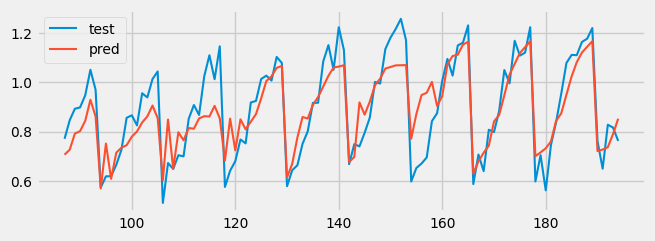

In [19]:
fig, ax = plt.subplots(figsize=(7, 2.5))
datos.loc[predicciones_backtest.index, 'y'].plot(ax=ax, label='test')
predicciones_backtest.plot(ax=ax, label='predicciones')
ax.legend();

In [20]:
# Importancia predictores
# ==============================================================================
impotancia = forecaster.get_feature_importances()
impotancia

,feature,importance
0,lag_1,0.009412
1,lag_2,0.087268
2,lag_3,0.012754
3,lag_4,0.001446
4,lag_5,0.000401
5,lag_6,0.001386
6,lag_7,0.001273
7,lag_8,0.006926
8,lag_9,0.005839
9,lag_10,0.013076
